<a href="https://colab.research.google.com/github/gloxy115/Active-Learning-for-Fake-News-Classification-Using-BERT/blob/main/Experiment_1_Baseline_Models(LR%2C_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import os
import random
import heapq
import gc
from scipy.spatial import distance_matrix
from IPython import display
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git  #install modAL package

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-tqkbjjl3
  Running command git clone -q https://github.com/modAL-python/modAL.git /tmp/pip-req-build-tqkbjjl3
  Created wheel for modAL: filename=modAL-0.4.1-py3-none-any.whl size=27938 sha256=d4dc5827217c0169cc6845bb27b994f1b0da43603218869c40ad8587e98b6fe8
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6dgz6s4/wheels/c1/2f/cc/f2157ab6d756e6ef8f9b2165f1baa6be615c9f25b93661957a
Successfully built modAL


In [ ]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling   #randomsampling is not included in the package so is defined as a function later

In [ ]:
def set_seed(x):  #setting the seed so the initial result is same for the same model
  seed_value= x
  # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # 2. Set `python` built-in pseudo-random generator at a fixed valu
  random.seed(seed_value)

  # 3. Set `numpy` pseudo-random generator at a fixed value

  np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value

  tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
  from keras import backend as K

  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.keras.utils.set_random_seed(seed_value)  # sets seeds for base-python, numpy and tf
  tf.config.experimental.enable_op_determinism()


# select a data to have it as a train_data, in this notebook, I ran it for ISOT

In [ ]:
#ISOT

train_data = pd.read_csv(path + 'ISOT_may.csv', encoding="ISO-8859-1")


In [ ]:
#politifact

#train_data = pd.read_csv(path + 'Politifact_may.csv', encoding="ISO-8859-1")


In [ ]:
#cc

#train_data = pd.read_csv(path + 'CC_may.csv', encoding="ISO-8859-1")


In [ ]:
#kaggle

#train_data = pd.read_csv(path + 'Kaggle_may.csv', encoding="ISO-8859-1")


In [ ]:
#covid

#train_data = pd.read_csv(path + 'Covid_may.csv', encoding="ISO-8859-1")


Prep

In [ ]:
set_seed(555)  #setting the seed 

In [ ]:
def trun(data):  #this function truncates the text data so its same length(510) as the input for BERT
    normalized = []
    for i in data:
        i = ' '.join(i.split()[:510])
        normalized.append(i)
    return normalized

In [ ]:
TEST_SIZE=0.3 #30% of the dataset is test data

train_data=train_data.dropna()
train_data=train_data[['text','labels']]  
train_data=train_data.drop_duplicates(subset=['text', 'labels'], keep='last')

if len(train_data)>15000:  # if the dataset is more than 15000 instances, randomly select 15000
  train_data = train_data.sample(15000).reset_index(drop=True)

train_data, test_data = train_test_split(train_data, test_size=TEST_SIZE)
train_data = train_data.reset_index(drop=True)

##first 510 words
train_data['text']=trun(train_data['text'])
train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['labels']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['labels']), test_data)))

train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1

Logistic Regression with modAL package

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3))
e=vectorizer.fit_transform(train_texts)
l=vectorizer.transform(test_texts)

# assemble initial data
n_initial = 100
initial_idx = np.random.choice(range(len(train_texts)), size=n_initial, replace=False)
X_initial = np.array(train_texts)[initial_idx]
y_initial = np.array(train_labels)[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(train_texts, initial_idx, axis=0)
y_pool = np.delete(train_labels, initial_idx, axis=0)

In [ ]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    X_training=vectorizer.transform(X_initial), y_training=y_initial,
)

# the active learning loop
LR_uncertainty_results = [accuracy_score(test_labels, learner.predict(l))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(vectorizer.transform(X_pool), n_instances=100)
    learner.teach(
        X=vectorizer.transform(X_pool[query_idx]), y=y_pool[query_idx]
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    LR_uncertainty_results.append(accuracy_score(test_labels, learner.predict(l)))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5


In [ ]:
LR_uncertainty_results  #Logistic regression + Uncertainty sampling results

[0.8604444444444445,
 0.9417777777777778,
 0.9564444444444444,
 0.9682222222222222,
 0.9677777777777777,
 0.9722222222222222]

In [ ]:
def random_sampling(classifier, X_pool,n_instances):  #defining random sampling
    n_samples = 100
    query_idx = np.random.choice(range(n_samples),size=n_instances)
    return query_idx, X_pool[query_idx]


del learner
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=random_sampling,
    X_training=vectorizer.transform(X_initial), y_training=y_initial,
)

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(train_texts, initial_idx, axis=0)
y_pool = np.delete(train_labels, initial_idx, axis=0)

# the active learning loop
LR_random_results = [accuracy_score(test_labels, learner.predict(l))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(vectorizer.transform(X_pool), n_instances=100)
    learner.teach(
        X=vectorizer.transform(X_pool[query_idx]), y=y_pool[query_idx]
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    LR_random_results.append(accuracy_score(test_labels, learner.predict(l)))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5


In [ ]:
LR_random_results   #Logistic Regression + Random Sampling results

[0.8604444444444445,
 0.8922222222222222,
 0.9128888888888889,
 0.9284444444444444,
 0.9388888888888889,
 0.9455555555555556]

LSTM with modAL package

In [ ]:
set_seed(555)

In [ ]:
#ISOT
train_data = pd.read_csv(path + 'ISOT_may.csv', encoding="ISO-8859-1")


In [ ]:
train_data=train_data.dropna()
train_data=train_data[['text','labels']] 
train_data=train_data.drop_duplicates(subset=['text', 'labels'], keep='last')

TEST_SIZE=0.3
if len(train_data)>15000:
  train_data = train_data.sample(15000).reset_index(drop=True)


train_data, test_data = train_test_split(train_data, test_size=TEST_SIZE)
train_data = train_data.reset_index(drop=True)

X_train=train_data['text']
y_train=train_data['labels']
X_test=test_data['text']
y_test=test_data['labels']

vocab_size = 10000
embedding_dim = 64
max_length = 510  
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
pool_idx=[x for x in list(np.arange(0,len(X_train))) if (x not in initial_idx)]
pool_idx=np.array(pool_idx)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx].to_numpy()

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = y_train[pool_idx].to_numpy()


#LSTM model created with Keras package
def keras_LSTM():
    model=Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim))
    model.add(layers.Bidirectional(layers.LSTM(embedding_dim,  return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(16)))
    model.add(layers.Dense(embedding_dim,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    print(model.summary())
    return model
keras_lstm=KerasClassifier(keras_LSTM)

def random_sampling(classifier, X_pool,n_instances):
    n_samples = 100
    query_idx = np.random.choice(range(n_samples),size=n_instances)
    return query_idx, X_pool[query_idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
# initialize ActiveLearner for random sampling
learner = ActiveLearner(
    estimator=keras_lstm,
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial, epochs=10, shuffle=True, batch_size=16,verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 - 12s - loss: 0.6926 - accuracy: 0.5700 - 12s/epoch - 2s/step
Epoch 2/10
7/7 - 0s - loss: 0.6914 - accuracy: 0.5600 - 395ms/epoch - 56ms/step
Epoch 3/10
7/7 - 0s - loss: 0.6910 - accuracy: 0.5300 - 383ms/epoch - 55ms/step
Epoch 4/10
7/7 - 0s - loss: 0.6903 - accuracy: 0.6000 - 392ms/epoch - 56ms/step
Epoch 5/10
7/7 - 0s - loss: 0.6886 - accuracy: 0.6500 - 405ms/epoch - 58ms/step
Epoch 6/10
7/7 - 0s - loss: 0.6861 - accuracy: 0.6700 - 381ms/epoch - 54ms/step
Epoch 7/10
7/7 - 0s - loss: 0.6872 - accuracy: 0.6600 - 385ms/epoch - 55ms/step
Epoch 8/10
7/7 - 0s - loss: 0.6849 - accuracy: 0.6900 - 392ms/epoch - 56ms/step
Epoch 9/10
7/7 - 0s - loss: 0.6824 - accuracy: 0.7100 - 391ms/epoch - 56ms/step
Epoch 10/10
7/7 - 0s - loss: 0.6798 - accuracy: 0.7000 - 396ms/epoch - 57ms/step


In [ ]:
accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))

0.5402222222222223

In [ ]:
# the active learning loop

lstm_random_results = [accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))]

#lstm_random_results = [f1_score(y_test, learner.predict(X_test))]

n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,epochs=10, shuffle=True, batch_size=16,verbose=2
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    lstm_random_results.append(accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int)))
del learner

Query no. 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13/13 - 6s - loss: 0.6932 - accuracy: 0.4600 - 6s/epoch - 488ms/step
Epoch 2/10
13/13 - 1s - loss: 0.6928 - accuracy: 0.5000 - 716ms/epoch - 55ms/step
Epoch 3/10
13/13 - 1s - loss: 0.6916 - accuracy: 0.5900 - 757ms/epoch - 58ms/step
Epoch 4/10
13/13 - 1s - loss: 0.6905 - accuracy: 0.6000 - 726ms/epoch - 56ms/step
Epoch 5/10
13/13 - 1s - loss: 0.6892 - accuracy: 0.6600 - 742ms/epoch - 57ms/step
Epoch 6/10
13/13 - 1s - loss: 0.6871 - accuracy: 0.7000 - 730ms/epoch - 56ms/step
Epoch 7/10
13/13 - 1s - loss: 0.6856 - accuracy: 0.7100 - 723ms/epoch - 56ms/step
Epoch 8/10
13/13 - 1s - loss: 0.6807 - accuracy: 0.8000 - 722ms/epoch - 56ms/step
Epoch 9/10
13/13 - 1s - loss: 0.6737 - accuracy: 0.8450 - 713ms/epoch - 55ms/step
Epoch 10/10
13/13 - 1s - loss: 0.6627 - accuracy: 0.9050 - 733ms/epoch - 56ms/step
Query no. 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 - 7s - loss: 0.6933 - accuracy: 0.4800 - 7s/epoch - 359ms/step
Epoch 2/10
19/19 - 1s - loss: 0.6928 - accuracy: 0.5100 - 1s/epoch - 57ms/step
Epoch 3/10
19/19 - 1s - loss: 0.6917 - accuracy: 0.5933 - 1s/epoch - 59ms/step
Epoch 4/10
19/19 - 2s - loss: 0.6906 - accuracy: 0.6800 - 2s/epoch - 81ms/step
Epoch 5/10
19/19 - 1s - loss: 0.6886 - accuracy: 0.7300 - 1s/epoch - 55ms/step
Epoch 6/10
19/19 - 1s - loss: 0.6849 - accuracy: 0.8133 - 1s/epoch - 56ms/step
Epoch 7/10
19/19 - 1s - loss: 0.6748 - accuracy: 0.8967 - 1s/epoch - 55ms/step
Epoch 8/10
19/19 - 1s - loss: 0.6442 - accuracy: 0.8667 - 1s/epoch - 55ms/step
Epoch 9/10
19/19 - 1s - loss: 0.5748 - accuracy: 0.8600 - 1s/epoch - 55ms/step
Epoch 10/10
19/19 - 1s - loss: 0.4786 - accuracy: 0.9300 - 1s/epoch - 55ms/step
Query no. 3
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 - 6s - loss: 0.6930 - accuracy: 0.4950 - 6s/epoch - 259ms/step
Epoch 2/10
25/25 - 1s - loss: 0.6922 - accuracy: 0.5825 - 1s/epoch - 54ms/step
Epoch 3/10
25/25 - 1s - loss: 0.6907 - accuracy: 0.6500 - 1s/epoch - 54ms/step
Epoch 4/10
25/25 - 1s - loss: 0.6865 - accuracy: 0.7650 - 1s/epoch - 55ms/step
Epoch 5/10
25/25 - 1s - loss: 0.6771 - accuracy: 0.8850 - 1s/epoch - 55ms/step
Epoch 6/10
25/25 - 1s - loss: 0.6436 - accuracy: 0.9025 - 1s/epoch - 55ms/step
Epoch 7/10
25/25 - 1s - loss: 0.5130 - accuracy: 0.9050 - 1s/epoch - 55ms/step
Epoch 8/10
25/25 - 1s - loss: 0.3714 - accuracy: 0.9550 - 1s/epoch - 55ms/step
Epoch 9/10
25/25 - 1s - loss: 0.2426 - accuracy: 0.9550 - 1s/epoch - 54ms/step
Epoch 10/10
25/25 - 1s - loss: 0.1801 - accuracy: 0.9750 - 1s/epoch - 54ms/step
Query no. 4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 - 8s - loss: 0.6920 - accuracy: 0.5400 - 8s/epoch - 235ms/step
Epoch 2/10
32/32 - 2s - loss: 0.6895 - accuracy: 0.5920 - 2s/epoch - 54ms/step
Epoch 3/10
32/32 - 2s - loss: 0.6838 - accuracy: 0.6660 - 2s/epoch - 57ms/step
Epoch 4/10
32/32 - 2s - loss: 0.6542 - accuracy: 0.7840 - 2s/epoch - 55ms/step
Epoch 5/10
32/32 - 2s - loss: 0.5216 - accuracy: 0.8800 - 2s/epoch - 56ms/step
Epoch 6/10
32/32 - 2s - loss: 0.3900 - accuracy: 0.9700 - 2s/epoch - 55ms/step
Epoch 7/10
32/32 - 2s - loss: 0.2606 - accuracy: 0.9880 - 2s/epoch - 56ms/step
Epoch 8/10
32/32 - 2s - loss: 0.1647 - accuracy: 0.9940 - 2s/epoch - 57ms/step
Epoch 9/10
32/32 - 2s - loss: 0.1553 - accuracy: 0.9900 - 2s/epoch - 57ms/step
Epoch 10/10
32/32 - 2s - loss: 0.1247 - accuracy: 0.9860 - 2s/epoch - 56ms/step
Query no. 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 8s - loss: 0.6933 - accuracy: 0.5067 - 8s/epoch - 207ms/step
Epoch 2/10
38/38 - 2s - loss: 0.6911 - accuracy: 0.6333 - 2s/epoch - 56ms/step
Epoch 3/10
38/38 - 2s - loss: 0.6847 - accuracy: 0.7933 - 2s/epoch - 56ms/step
Epoch 4/10
38/38 - 2s - loss: 0.6566 - accuracy: 0.9200 - 2s/epoch - 56ms/step
Epoch 5/10
38/38 - 2s - loss: 0.5148 - accuracy: 0.8950 - 2s/epoch - 56ms/step
Epoch 6/10
38/38 - 2s - loss: 0.3372 - accuracy: 0.9283 - 2s/epoch - 55ms/step
Epoch 7/10
38/38 - 2s - loss: 0.2213 - accuracy: 0.9700 - 2s/epoch - 55ms/step
Epoch 8/10
38/38 - 2s - loss: 0.1713 - accuracy: 0.9783 - 2s/epoch - 56ms/step
Epoch 9/10
38/38 - 2s - loss: 0.2770 - accuracy: 0.9233 - 2s/epoch - 55ms/step
Epoch 10/10
38/38 - 2s - loss: 0.2000 - accuracy: 0.9517 - 2s/epoch - 56ms/step


In [ ]:
lstm_random_results #LSTM with Random Sampling results

[0.5402222222222223,
 0.7966666666666666,
 0.8824444444444445,
 0.9111111111111111,
 0.9022222222222223,
 0.8762222222222222]

In [ ]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = y_train[pool_idx].values

In [ ]:
set_seed(555)

In [ ]:
# initialize ActiveLearner for uncertainty sampling
learner = ActiveLearner(
    estimator=keras_lstm,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial, epochs=10, shuffle=True, batch_size=16,verbose=2
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 32)               18560     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 - 6s - loss: 0.6926 - accuracy: 0.5700 - 6s/epoch - 809ms/step
Epoch 2/10
7/7 - 0s - loss: 0.6914 - accuracy: 0.5600 - 386ms/epoch - 55ms/step
Epoch 3/10
7/7 - 0s - loss: 0.6910 - accuracy: 0.5300 - 390ms/epoch - 56ms/step
Epoch 4/10
7/7 - 0s - loss: 0.6903 - accuracy: 0.6000 - 394ms/epoch - 56ms/step
Epoch 5/10
7/7 - 0s - loss: 0.6886 - accuracy: 0.6500 - 412ms/epoch - 59ms/step
Epoch 6/10
7/7 - 0s - loss: 0.6861 - accuracy: 0.6700 - 390ms/epoch - 56ms/step
Epoch 7/10
7/7 - 0s - loss: 0.6872 - accuracy: 0.6600 - 399ms/epoch - 57ms/step
Epoch 8/10
7/7 - 0s - loss: 0.6849 - accuracy: 0.6900 - 391ms/epoch - 56ms/step
Epoch 9/10
7/7 - 0s - loss: 0.6824 - accuracy: 0.7100 - 391ms/epoch - 56ms/step
Epoch 10/10
7/7 - 0s - loss: 0.6798 - accuracy: 0.7000 - 396ms/epoch - 57ms/step


In [ ]:
accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))

0.5402222222222223

In [ ]:
# the active learning loop
lstm_uncertainty_results = [accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int))]
n_queries = 5
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=False,epochs=10, shuffle=True, batch_size=16,verbose=2
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    lstm_uncertainty_results.append(accuracy_score(y_test.astype(int), learner.predict(X_test).flatten().astype(int)))

Query no. 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 32)               18560     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13/13 - 6s - loss: 0.6928 - accuracy: 0.5400 - 6s/epoch - 470ms/step
Epoch 2/10
13/13 - 1s - loss: 0.6916 - accuracy: 0.6000 - 714ms/epoch - 55ms/step
Epoch 3/10
13/13 - 1s - loss: 0.6897 - accuracy: 0.6000 - 720ms/epoch - 55ms/step
Epoch 4/10
13/13 - 1s - loss: 0.6884 - accuracy: 0.5850 - 716ms/epoch - 55ms/step
Epoch 5/10
13/13 - 1s - loss: 0.6867 - accuracy: 0.5850 - 730ms/epoch - 56ms/step
Epoch 6/10
13/13 - 1s - loss: 0.6845 - accuracy: 0.5850 - 719ms/epoch - 55ms/step
Epoch 7/10
13/13 - 1s - loss: 0.6820 - accuracy: 0.5850 - 747ms/epoch - 57ms/step
Epoch 8/10
13/13 - 1s - loss: 0.6765 - accuracy: 0.5850 - 727ms/epoch - 56ms/step
Epoch 9/10
13/13 - 1s - loss: 0.6713 - accuracy: 0.5900 - 715ms/epoch - 55ms/step
Epoch 10/10
13/13 - 1s - loss: 0.6629 - accuracy: 0.5850 - 716ms/epoch - 55ms/step
Query no. 2
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 - 7s - loss: 0.6916 - accuracy: 0.5833 - 7s/epoch - 363ms/step
Epoch 2/10
19/19 - 1s - loss: 0.6874 - accuracy: 0.6067 - 1s/epoch - 56ms/step
Epoch 3/10
19/19 - 1s - loss: 0.6824 - accuracy: 0.6067 - 1s/epoch - 56ms/step
Epoch 4/10
19/19 - 1s - loss: 0.6762 - accuracy: 0.6067 - 1s/epoch - 56ms/step
Epoch 5/10
19/19 - 1s - loss: 0.6633 - accuracy: 0.6067 - 1s/epoch - 57ms/step
Epoch 6/10
19/19 - 1s - loss: 0.6314 - accuracy: 0.6067 - 1s/epoch - 57ms/step
Epoch 7/10
19/19 - 1s - loss: 0.5795 - accuracy: 0.6167 - 1s/epoch - 56ms/step
Epoch 8/10
19/19 - 1s - loss: 0.5230 - accuracy: 0.6500 - 1s/epoch - 56ms/step
Epoch 9/10
19/19 - 1s - loss: 0.4941 - accuracy: 0.7533 - 1s/epoch - 56ms/step
Epoch 10/10
19/19 - 1s - loss: 0.4289 - accuracy: 0.7767 - 1s/epoch - 56ms/step
Query no. 3
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 - 6s - loss: 0.6884 - accuracy: 0.7050 - 6s/epoch - 237ms/step
Epoch 2/10
25/25 - 1s - loss: 0.6786 - accuracy: 0.7600 - 1s/epoch - 56ms/step
Epoch 3/10
25/25 - 2s - loss: 0.6588 - accuracy: 0.7600 - 2s/epoch - 81ms/step
Epoch 4/10
25/25 - 2s - loss: 0.6221 - accuracy: 0.7525 - 2s/epoch - 70ms/step
Epoch 5/10
25/25 - 1s - loss: 0.5616 - accuracy: 0.7525 - 1s/epoch - 54ms/step
Epoch 6/10
25/25 - 1s - loss: 0.5342 - accuracy: 0.7525 - 1s/epoch - 54ms/step
Epoch 7/10
25/25 - 1s - loss: 0.4598 - accuracy: 0.7650 - 1s/epoch - 55ms/step
Epoch 8/10
25/25 - 1s - loss: 0.3471 - accuracy: 0.8725 - 1s/epoch - 54ms/step
Epoch 9/10
25/25 - 1s - loss: 0.2505 - accuracy: 0.9200 - 1s/epoch - 55ms/step
Epoch 10/10
25/25 - 1s - loss: 0.1974 - accuracy: 0.9575 - 1s/epoch - 55ms/step
Query no. 4
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 - 8s - loss: 0.6924 - accuracy: 0.5380 - 8s/epoch - 237ms/step
Epoch 2/10
32/32 - 2s - loss: 0.6890 - accuracy: 0.6440 - 2s/epoch - 56ms/step
Epoch 3/10
32/32 - 2s - loss: 0.6853 - accuracy: 0.6400 - 2s/epoch - 55ms/step
Epoch 4/10
32/32 - 2s - loss: 0.6764 - accuracy: 0.6920 - 2s/epoch - 56ms/step
Epoch 5/10
32/32 - 2s - loss: 0.6512 - accuracy: 0.7860 - 2s/epoch - 56ms/step
Epoch 6/10
32/32 - 2s - loss: 0.5742 - accuracy: 0.7840 - 2s/epoch - 57ms/step
Epoch 7/10
32/32 - 2s - loss: 0.4570 - accuracy: 0.9160 - 2s/epoch - 56ms/step
Epoch 8/10
32/32 - 2s - loss: 0.3085 - accuracy: 0.9560 - 2s/epoch - 56ms/step
Epoch 9/10
32/32 - 2s - loss: 0.2079 - accuracy: 0.9820 - 2s/epoch - 56ms/step
Epoch 10/10
32/32 - 2s - loss: 0.1490 - accuracy: 0.9840 - 2s/epoch - 56ms/step
Query no. 5
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 64)       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


38/38 - 8s - loss: 0.6928 - accuracy: 0.5533 - 8s/epoch - 208ms/step
Epoch 2/10
38/38 - 2s - loss: 0.6904 - accuracy: 0.6267 - 2s/epoch - 56ms/step
Epoch 3/10
38/38 - 2s - loss: 0.6864 - accuracy: 0.6533 - 2s/epoch - 56ms/step
Epoch 4/10
38/38 - 2s - loss: 0.6781 - accuracy: 0.6533 - 2s/epoch - 55ms/step
Epoch 5/10
38/38 - 2s - loss: 0.6468 - accuracy: 0.7300 - 2s/epoch - 56ms/step
Epoch 6/10
38/38 - 2s - loss: 0.5209 - accuracy: 0.8583 - 2s/epoch - 55ms/step
Epoch 7/10
38/38 - 2s - loss: 0.2996 - accuracy: 0.9567 - 2s/epoch - 55ms/step
Epoch 8/10
38/38 - 2s - loss: 0.1708 - accuracy: 0.9967 - 2s/epoch - 55ms/step
Epoch 9/10
38/38 - 2s - loss: 0.1054 - accuracy: 0.9967 - 2s/epoch - 56ms/step
Epoch 10/10
38/38 - 2s - loss: 0.0783 - accuracy: 0.9917 - 2s/epoch - 56ms/step


In [ ]:
lstm_uncertainty_results #LSTM with uncertainty sampling

[0.5402222222222223,
 0.5548888888888889,
 0.6304444444444445,
 0.858,
 0.9191111111111111,
 0.9411111111111111]

These results are then saved, run 5 times and then averaged to make the final graphs for the paper

Draw graphs- an example of a graph for baseline models only. 

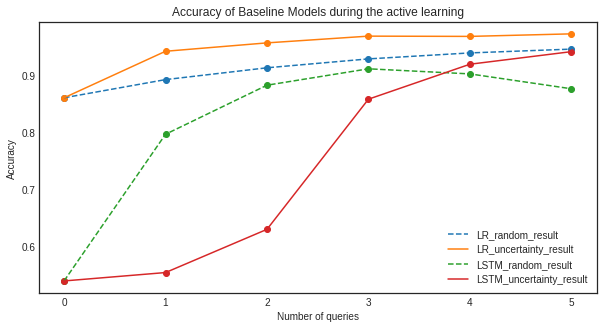

In [ ]:
#######################Graph for the baseline model results

len_num=len(LR_random_results)
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of Baseline Models during the active learning')
    plt.plot(np.arange(len_num), LR_random_results, label="LR_random_result",linestyle='dashed')
    plt.scatter(np.arange(len_num), LR_random_results)
    plt.plot(np.arange(len_num), LR_uncertainty_results, label="LR_uncertainty_result")
    plt.scatter(np.arange(len_num), LR_uncertainty_results)
    plt.plot(np.arange(len_num), lstm_random_results, label="LSTM_random_result",linestyle='dashed')
    plt.scatter(np.arange(len_num), lstm_random_results)
    plt.plot(np.arange(len_num), lstm_uncertainty_results, label="LSTM_uncertainty_result")
    plt.scatter(np.arange(len_num), lstm_uncertainty_results)
    plt.xlabel('Number of queries')
    plt.ylabel('Accuracy')
    plt.legend(loc="lower right")
    plt.xticks(range(0,len_num))
    plt.show()